In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
from  datetime import datetime, timedelta
import os
import gc

In [10]:
calendar = pd.read_csv(r'C:\Users\nonta\Dropbox\My PC (LAPTOP-VMKUGGQ6)\Desktop\Master-DS\Forecasting\Final_Project\sales-time-series-forecasting-tx-afcs2021\calendar_afcs2021.csv')
sell_prices = pd.read_csv(r'C:\Users\nonta\Dropbox\My PC (LAPTOP-VMKUGGQ6)\Desktop\Master-DS\Forecasting\Final_Project\sales-time-series-forecasting-tx-afcs2021\sell_prices_afcs2021.csv')
sales_train = pd.read_csv(r'C:\Users\nonta\Dropbox\My PC (LAPTOP-VMKUGGQ6)\Desktop\Master-DS\Forecasting\Final_Project\sales-time-series-forecasting-tx-afcs2021\sales_train_validation_afcs2021.csv')
sales_test = pd.read_csv(r'C:\Users\nonta\Dropbox\My PC (LAPTOP-VMKUGGQ6)\Desktop\Master-DS\Forecasting\Final_Project\sales-time-series-forecasting-tx-afcs2021\sales_test_validation_afcs2021.csv')

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Imports
import os 
import re
import warnings
from tqdm import tqdm
import datetime as dt

# ML/DL imports
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
#init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

### Useful Functions

In [4]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [5]:
def split_sequences(sequences, timesteps, horizon):
    Sequences, Targets = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + timesteps
        out_end_ix = end_ix + horizon-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        Sequences.append(seq_x)
        Targets.append(seq_y)
        show_shapes()
    return array(X), array(y)

In [6]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX']
    for feature in cat:
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [7]:
def Normalize(list):
    list = np.array(list)
    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list

In [8]:
def show_shapes(Sequences, Targets): # this'll use inputs; can make yours to use local variable values
    print("Expected: (num_samples, timesteps, channels)")
    print("Sequences: {}".format(Sequences.shape))
    print("Targets:   {}".format(Targets.shape))  

#### Calendar Data

In [11]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX',"wday","month"]].values.T, index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX',"wday","month"], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", str(x)) else np.nan).fillna(10)

In [12]:
calendar['date'] = pd.to_datetime(calendar['date'])

calendar= transform(calendar)

# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX',"wday","month"]].values.T,
                            index=['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX',"wday","month"])
transfer_cal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
event_name_1,30,30,30,30,30,30,30,30,26,30,30,30,30,30,30,30,28,30,30,30,30,30,30,22,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,11,30,30,30,30,30,30,12,25,30,30,23,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,20,30,21,30,30,30,30,30,30,30,30,2,30,30,15,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,14,17,30,30,30,30,30,30,30,30,30,30,30,16,30,30,30,30,30,30,7,30,30,30,30,30,30,30,30,30,30,30,30,30,30,9,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,24,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,5,30,30,30,30,10,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,8,30,30,30,30,30,30,30,30,30,30,29,30,30,30,30,30,30,30,30,30,30,30,30,30,30,27,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,30,30,30,30,30,30,30,30,30,30,1,30,30,30,30,30,30,18,30,30,30,30,30,19,30,30,30,30,30,30,30,30,30,30,13,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,26,30,30,11,30,30,30,28,22,30,12,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,25,30,30,30,30,30,30,23,30,30,4,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,21,20,30,30,30,2,30,30,15,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,14,30,30,17,30,30,30,30,24,30,30,30,30,30,30,30,30,30,30,30,16
event_type_1,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,4,0,4,4,4,4,4,4,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,4,4,4,4,4,2,0,4,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,2,4,4,4,4,4,4,4,4,0,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,3,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,4,4,4,4,4,4,4,4,4,4,

#### Sales prices

In [13]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'], how = 'left')
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
price_fea.head()

,wm_yr_wk,date,store_id,item_id,sell_price,id
0,11101,2011-01-29,TX_3,FOODS_3_001,2.28,FOODS_3_001_TX_3_validation
1,11101,2011-01-29,TX_3,FOODS_3_005,1.68,FOODS_3_005_TX_3_validation
2,11101,2011-01-29,TX_3,FOODS_3_007,0.20,FOODS_3_007_TX_3_validation
3,11101,2011-01-29,TX_3,FOODS_3_011,1.98,FOODS_3_011_TX_3_validation
4,11101,2011-01-29,TX_3,FOODS_3_014,1.98,FOODS_3_014_TX_3_validation


In [14]:
df = price_fea.pivot('id','date','sell_price')
price_df = sales_train.merge(df,on=['id'],how= 'left').iloc[:,1914:]
price_df.index = sales_train.id
price_df.head()

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,2011-02-08,2011-02-09,2011-02-10,2011-02-11,2011-02-12,2011-02-13,2011-02-14,2011-02-15,2011-02-16,2011-02-17,2011-02-18,2011-02-19,2011-02-20,2011-02-21,2011-02-22,2011-02-23,2011-02-24,2011-02-25,2011-02-26,2011-02-27,2011-02-28,2011-03-01,2011-03-02,2011-03-03,2011-03-04,2011-03-05,2011-03-06,2011-03-07,2011-03-08,2011-03-09,2011-03-10,2011-03-11,2011-03-12,2011-03-13,2011-03-14,2011-03-15,2011-03-16,2011-03-17,2011-03-18,2011-03-19,2011-03-20,2011-03-21,2011-03-22,2011-03-23,2011-03-24,2011-03-25,2011-03-26,2011-03-27,2011-03-28,2011-03-29,2011-03-30,2011-03-31,2011-04-01,2011-04-02,2011-04-03,2011-04-04,2011-04-05,2011-04-06,2011-04-07,2011-04-08,2011-04-09,2011-04-10,2011-04-11,2011-04-12,2011-04-13,2011-04-14,2011-04-15,2011-04-16,2011-04-17,2011-04-18,2011-04-19,2011-04-20,2011-04-21,2011-04-22,2011-04-23,2011-04-24,2011-04-25,2011-04-26,2011-04-27,2011-04-28,2011-04-29,2011-04-30,2011-05-01,2011-05-02,2011-05-03,2011-05-04,2011-05-05,2011-05-06,2011-05-07,2011-05-08,2011-05-09,2011-05-10,2011-05-11,2011-05-12,2011-05-13,2011-05-14,2011-05-15,2011-05-16,2011-05-17,2011-05-18,2011-05-19,2011-05-20,2011-05-21,2011-05-22,2011-05-23,2011-05-24,2011-05-25,2011-05-26,2011-05-27,2011-05-28,2011-05-29,2011-05-30,2011-05-31,2011-06-01,2011-06-02,2011-06-03,2011-06-04,2011-06-05,2011-06-06,2011-06-07,2011-06-08,2011-06-09,2011-06-10,2011-06-11,2011-06-12,2011-06-13,2011-06-14,2011-06-15,2011-06-16,2011-06-17,2011-06-18,2011-06-19,2011-06-20,2011-06-21,2011-06-22,2011-06-23,2011-06-24,2011-06-25,2011-06-26,2011-06-27,2011-06-28,2011-06-29,2011-06-30,2011-07-01,2011-07-02,2011-07-03,2011-07-04,2011-07-05,2011-07-06,2011-07-07,2011-07-08,2011-07-09,2011-07-10,2011-07-11,2011-07-12,2011-07-13,2011-07-14,2011-07-15,2011-07-16,2011-07-17,2011-07-18,2011-07-19,2011-07-20,2011-07-21,2011-07-22,2011-07-23,2011-07-24,2011-07-25,2011-07-26,2011-07-27,2011-07-28,2011-07-29,2011-07-30,2011-07-31,2011-08-01,2011-08-02,2011-08-03,2011-08-04,2011-08-05,2011-08-06,2011-08-07,2011-08-08,2011-08-09,2011-08-10,2011-08-11,2011-08-12,2011-08-13,2011-08-14,2011-08-15,2011-08-16,2011-08-17,2011-08-18,2011-08-19,2011-08-20,2011-08-21,2011-08-22,2011-08-23,2011-08-24,2011-08-25,2011-08-26,2011-08-27,2011-08-28,2011-08-29,2011-08-30,2011-08-31,2011-09-01,2011-09-02,2011-09-03,2011-09-04,2011-09-05,2011-09-06,2011-09-07,2011-09-08,2011-09-09,2011-09-10,2011-09-11,2011-09-12,2011-09-13,2011-09-14,2011-09-15,2011-09-16,2011-09-17,2011-09-18,2011-09-19,2011-09-20,2011-09-21,2011-09-22,2011-09-23,2011-09-24,2011-09-25,2011-09-26,2011-09-27,2011-09-28,2011-09-29,2011-09-30,2011-10-01,2011-10-02,2011-10-03,2011-10-04,2011-10-05,...,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,20

#### Sales data

In [15]:
sales_test.reset_index(drop=True,inplace=True)

In [16]:
df_1941 = pd.concat([sales_train,sales_test.drop("id",axis=1)],axis=1)

In [17]:
df_1941 = df_1941.set_index("id")

In [18]:
train_data = downcast_dtypes(df_1941)

#### Combining Datasets

In [20]:
price_df = price_df.iloc[:,:1941]
transfer_cal = transfer_cal.iloc[:,:1941]

In [21]:
time_series_col1 = train_data.columns
time_series_col2 = price_df.columns
time_series_col3 = transfer_cal.columns

print(len(time_series_col1),len(time_series_col2),len(time_series_col3))

1941 1941 1941


In [22]:
price_df.columns = time_series_col1
transfer_cal.columns = time_series_col1

train_data.shape, price_df.shape, transfer_cal.shape

((823, 1941), (823, 1941), (7, 1941))

In [23]:
full_train_data = pd.concat([train_data, transfer_cal, price_df], axis=0)
full_train_data.tail(10)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
FOODS_3_818_TX_3_validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Train the Model

In [24]:
full_train_data_transposed = full_train_data.T

In [25]:
cols = full_train_data_transposed.dtypes.index.tolist()
types = full_train_data_transposed.dtypes.values.tolist()
object_cols = [col for i,col in enumerate(cols)
           if types[i] == "object" and col != "date"]

print("Categorical Columns:")
len(object_cols)

Categorical Columns:


0

In [26]:
cols = full_train_data_transposed.dtypes.index.tolist()
types = full_train_data_transposed.dtypes.values.tolist()
object_cols = [col for i,col in enumerate(cols)
           if types[i] in ['int64', 'float64', 'int16', 'float32'] 
               and col not in ['event_name_1','event_type_1','event_name_2','event_type_2','snap_TX']]

print("Numerical Columns:")
len(object_cols)

Numerical Columns:


1648

In [27]:
from tqdm import tqdm
timesteps = 28
horizon = 28

full_train_data_sequenced = []   

for i in tqdm(range(train_data.shape[0])):      # Using tqdm to visualize the progress

    full_train_data_sequenced.append([list(t) for t in zip(full_train_data_transposed['event_name_1'],
                                       full_train_data_transposed['event_type_1'],
                                       full_train_data_transposed['event_name_2'],     
                                       full_train_data_transposed['event_type_2'],
                                       full_train_data_transposed['snap_TX'],
                                       full_train_data_transposed['wday'],
                                       full_train_data_transposed['month'], 
                                       price_df.iloc[i],
                                       train_data.iloc[i])])
    
full_train_data_sequenced = np.asarray(full_train_data_sequenced, dtype=np.float32)

100%|████████████████████████████████████████████████████████████████████████████████| 823/823 [00:08<00:00, 93.42it/s]


In [28]:
norm_full_train_data, train_low, train_high = Normalize(full_train_data_sequenced[:,-(timesteps*2):,:])

In [29]:
print(norm_full_train_data.shape)
print(train_low)
print(train_high)

(823, 56, 9)
0.0
146.0


In [30]:
num_features = 9

X_train = norm_full_train_data[:,-28*4:-28,:]
y_train = norm_full_train_data[:,-28:,8]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

show_shapes(X_train, y_train)

Expected: (num_samples, timesteps, channels)
Sequences: (823, 28, 9)
Targets:   (823, 28, 1)


#### Creating LSTM model

In [31]:
def encoder_decoder_model():
    
    # Use Keras sequential model
    model = Sequential()
    
    # Encoder LSTM layer with Dropout regularisation; Set return_sequences to False since we are feeding last output to decoder layer
    model.add(LSTM(units = 100, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # The fixed-length output of the encoder is repeated, once for each required time step in the output sequence with the RepeatVector wrapper
    model.add(RepeatVector(horizon))
    
    # Decoder LSTM layer with Dropout regularisation; Set return_sequences to True to feed each output time step to a Dense layer
    model.add(LSTM(units = 100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    
    # Same dense layer is repeated for each output timestep with the TimeDistributed wrapper
    model.add(TimeDistributed(Dense(units=1, activation = "linear")))
    
    return model

In [32]:
model = encoder_decoder_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 28, 100)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 28, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 28, 100)           0         
                                                                 
 time_distributed (TimeDistr  (None, 28, 1)            101       
 ibuted)                                                

In [33]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

In [34]:
his=model.fit(X_train,y_train,epochs=15,batch_size=1000,verbose=2)

Epoch 1/15
1/1 - 4s - loss: 0.0016 - accuracy: 0.4672 - 4s/epoch - 4s/step
Epoch 2/15
1/1 - 0s - loss: 0.0015 - accuracy: 0.4672 - 420ms/epoch - 420ms/step
Epoch 3/15
1/1 - 0s - loss: 0.0015 - accuracy: 0.4672 - 376ms/epoch - 376ms/step
Epoch 4/15
1/1 - 0s - loss: 0.0014 - accuracy: 0.4672 - 399ms/epoch - 399ms/step
Epoch 5/15
1/1 - 0s - loss: 0.0013 - accuracy: 0.4672 - 396ms/epoch - 396ms/step
Epoch 6/15
1/1 - 0s - loss: 0.0013 - accuracy: 0.4672 - 391ms/epoch - 391ms/step
Epoch 7/15
1/1 - 0s - loss: 0.0013 - accuracy: 0.4672 - 405ms/epoch - 405ms/step
Epoch 8/15
1/1 - 0s - loss: 0.0012 - accuracy: 0.4672 - 379ms/epoch - 379ms/step
Epoch 9/15
1/1 - 0s - loss: 0.0012 - accuracy: 0.4672 - 424ms/epoch - 424ms/step
Epoch 10/15
1/1 - 0s - loss: 0.0011 - accuracy: 0.4672 - 408ms/epoch - 408ms/step
Epoch 11/15
1/1 - 0s - loss: 0.0011 - accuracy: 0.4672 - 425ms/epoch - 425ms/step
Epoch 12/15
1/1 - 0s - loss: 0.0010 - accuracy: 0.4672 - 434ms/epoch - 434ms/step
Epoch 13/15
1/1 - 0s - loss: 8.

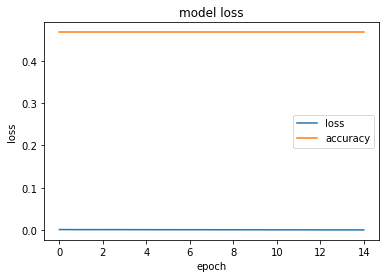

In [35]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'])
plt.show()

In [36]:
# Take last 28 days in the past to predict the next 28 days in the future
test_input = np.array(X_train[:, -timesteps:, :]) # Here timesteps=28
test_input = test_input.reshape((X_train.shape[0], timesteps, num_features)) # Very important to reshape to assure that the test input has the correct shape (# samples, # timesteps, # features)
print(test_input.shape)

# Predict the next 28 days 
y_test = model.predict(test_input[:,-timesteps:, :], verbose=2)

# Concatenate prediction with past timesteps
test_forecast= np.concatenate((test_input[:,:,6].reshape(test_input.shape[0],test_input.shape[1]), 
                           y_test.astype(np.float32).reshape(test_input.shape[0],test_input.shape[1])),axis=1).reshape((test_input.shape[0],test_input.shape[1]+28,1))
print(y_test)
print(test_forecast.shape)

(823, 28, 9)
26/26 - 1s - 1s/epoch - 42ms/step
[[[0.00420035]
  [0.00545168]
  [0.00634655]
  ...
  [0.0086356 ]
  [0.00863457]
  [0.00863351]]

 [[0.00324327]
  [0.00368612]
  [0.00394322]
  ...
  [0.00362979]
  [0.003624  ]
  [0.00361914]]

 [[0.00370576]
  [0.00452584]
  [0.00508854]
  ...
  [0.00590967]
  [0.00590519]
  [0.00590135]]

 ...

 [[0.00450423]
  [0.00601469]
  [0.00712193]
  ...
  [0.01021994]
  [0.01021969]
  [0.0102193 ]]

 [[0.0049862 ]
  [0.00687291]
  [0.0082683 ]
  ...
  [0.01282888]
  [0.01283113]
  [0.01283272]]

 [[0.00392702]
  [0.00495174]
  [0.00566459]
  ...
  [0.007254  ]
  [0.00725124]
  [0.00724873]]]
(823, 56, 1)


In [37]:
# Reverse normalize to obtain human interpratable values
test_forecast = FNoramlize(test_forecast,train_low,train_high)

# Round values
test_forecast = np.rint(test_forecast)

In [38]:
forecast = pd.DataFrame(test_forecast.reshape(test_forecast.shape[0],test_forecast.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] = 0
forecast

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
819,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
820,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
821,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
